# Procesamiento del Lenguaje Natural

<img src="README.assets/nlp.png" alt="pln"/>

## Generación de un modelo de lenguaje utilizando redes neuronales

_Autor: Rodrigo Francisco Pablo_

El modelo del lenguaje neuronal propuesto por Bengio (2003) es un modelo que estima probabilidades a partir de una red neuronal FeedForward. Como otros modelos, se puede entender como una tupla:

$$\mu = (\Sigma, P)$$

donde $\Sigma$ es el vocabulario de palabras y $P = p(w_j|w_i)$ es la probabilidad de transición de $w_i$ a $w_j$. En este caso $P$ es una red FeedForward con una arquitectura constituida por:

* Una capa de embedding.
* Una capa oculta con activación $\tanh$.
* Una capa de salida con activación Softmax para obtener las probabilidades de transición.


### Configuraciones previas

Se realizan los *imports* necesarios para la creación del modelo. Para la creación del modelo se puede hacer uso de PyTorch o Tensorflow o cualquier otra librería que tenga redes neuronales pre-entrenadas, sin embargo, para este ejercicio se creará la red desde cero utilizando simplemente _numpy_.

In [1]:
#-*- encoding:utf-8 -*-

import numpy as np
from collections import defaultdict, Counter
from itertools import chain

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from nltk.tokenize import sent_tokenize, word_tokenize

from tqdm import tqdm
from sklearn.decomposition import PCA
from operator import itemgetter

Definimos tres funciones:

* Función para crear el vocabulario: asocia índices numéricos a palabras
* Función para asociar a cada elemento, una palabra
* Función para visualizar los embeddings por reducción de dimensionalidad con PCA

In [2]:
# Funcion que crea un vocabulario de palabras con un indice numero
def vocab():
    vocab = defaultdict()
    vocab.default_factory = lambda: len (vocab)
    return vocab

# Funcion que pasa la cadena de simbolos a una secuencia con indices numericos
def text2numba(corpus, vocab):
    for doc in corpus:
        yield [vocab[w] for w in doc]
        
#Función para visualizar los embeddings
#Usa reducción de la dimensionalidad por PCA
def plot_words(Z,ids):
    Z = PCA(2).fit_transform(Z)
    r=0
    plt.scatter(Z[:,0],Z[:,1], marker='o', c='blue')
    for label,x,y in zip(ids, Z[:,0], Z[:,1]):
        plt.annotate(label, xy=(x,y), xytext=(-1,1), textcoords='offset points', ha='center', va='bottom')
        r+=1
    plt.show()

### Elección de un corpus

Un **corpus** es una muestra bien organizada del nuestro lenguaje tomada de materiales escritos o hablados y que se encuentran agrupados bajo un críterio común. Para esta práctica se utilizará un corpus en *español*.

Obtenemos las sentencias con las que vamos a trabajar. Tokenizamos por oraciones y cada oración, a su vez, es tokenizada por palabras para obtener los elementos que servirán para el modelo del lenguaje.

Posteriormente, separamos los datos del corpus en el corpus de entrenamiento y el de evaluación:

In [3]:
# OPCION 1
sents =  [word_tokenize(s) for s in sent_tokenize(open('corpus/funes_el_memorioso.txt','r').read())]

#Split en corpus train y test
corpus, corpus_eval = train_test_split(sents, test_size=0.3)

print('Número de oraciones en train:',len(corpus))
print('Número de oraciones en test:',len(corpus_eval))

Número de oraciones en train: 88
Número de oraciones en test: 39


In [4]:
# OPCION 2
#import nltk
#nltk.download('gutenberg')
#sents = cess_esp.sents()
#nltk.download('punkt')
#sents = nltk.corpus.gutenberg.sents('shakespeare-macbeth.txt')

# #Split en corpus train y test
# corpus, corpus_eval = train_test_split(sents, test_size=0.3)

# print('Número de oraciones en train:',len(corpus))
# print('Número de oraciones en test:',len(corpus_eval))

También podemos ver el número de tipos y tokens con el que cuenta el texto:

In [5]:
#Frecuencia de los tipos
freq_words= Counter( chain(*[' '.join(sent).lower().split() for sent in corpus]) )

print('Número de tipos: {} \nNúmero de tokens: {}'.format(len(freq_words), sum(freq_words.values())))

Número de tipos: 873 
Número de tokens: 2244


### Sustitución de los hapax

Ahora sustituiremos elementos del texto por el símbolo de fuera del vocabulario (Out Of Vocabulary) o $OOV$ esto nos permitirá manejar elementos que no se observen durante el entrenamiento.

In [6]:
#Nuevo corpus remplazando hápax por OOV
corpus_hapax = []
#Reemplazamos los hápax por OOV
for sent in corpus:
  sent_hapax =[]
  for w in sent:
    #Si es hápax
    if freq_words[w.lower()] == 1:
      #Se reemplaza por <oov>
      sent_hapax.append('<oov>')
    else:
      #De otra forma se mantiene la palabra en mínuscula
      sent_hapax.append(w.lower())
  #Se agrupan las cadenas    
  corpus_hapax.append(sent_hapax)
    
#print(corpus_hapax)

### 1.  Stemming

Para esta tarea no realizará el proceso de steamming con la finalidad de simplificar la validación del modelo, ya que de otra manera se deberían reconstruir las cadenas a la hora de evaluar el modelo o a la hora de usarlo para alguna aplicación, por ejemplo, la generación de oraciones.

### 2. Insertar símbolos de inicio y final de cadena

Se indexa númericamente cada simbolo del vocabulario

In [7]:
# Llamamos a la funcion para crear un vocabulario
idx = vocab() # Simplemente se renombra la funcion

cads_idx = list(text2numba(corpus_hapax,idx))

Además, se colocarán etiquetas al inicio y al final de cada sentencia: BOS (Beginning of Sentence) y EOS (End of Sentence) respectivamente.

In [8]:
BOS = '<BOS>'
EOS = '<EOS>'

# A cada etiqueta se le asigna el indice número mayor 
# que el último indice asignado al vocabulario

BOS_IDX = max(idx.values()) + 2
EOS_IDX = max(idx.values()) + 1

# Se agregan las etiquetas al vocabulario
idx[EOS] = EOS_IDX
idx[BOS] = BOS_IDX

# Agregamos las etiquetas BOS al inicio y EOS al final de cada sentencia

strings = [[BOS_IDX] + cad + [EOS_IDX] for cad in cads_idx]

### 3. Bigramas

Antes de entrenar el modelo del lenguaje obtendremos los pares de entrenamiento que serán los pares obtenidos de bigramas, de tal forma que nuestro conjunto supervisado será:

$$\mathcal{S} = \{(i,j) : (w_i, w_j) \text{ es un bigrama}\}$$

In [9]:
# Creacion de bigramas
bigrams = list(chain(*[zip(cad,cad[1:]) for cad in strings]))
print("tamaño de los bigramas construidos: {}".format(len(bigrams)))

print("Bigramas: ")
print(bigrams[:10])

tamaño de los bigramas construidos: 2332
Bigramas: 
[(195, 0), (0, 0), (0, 0), (0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 0)]


### 4. Entrenamiento de la red neuronal

Como se mencionó al inicio, el modelo del lenguaje natural propuesto se base en la arquitectura porpuesta por Bengio(2003), la cual es una red neuronal de 3 capas, como se puede observar en la siguiente figura:

<img src="README.assets/arquitectura.png" alt="arquitectura" width="200"/>

Para la fase de *FORWARD*:

* Las entradas son vectores *one-hot* creados apartir de los indices de cada palabra en el vocabulario de entrenamiento. Por lo tanto si se tiene una palabra $w_3$, con indice 3, entonces el vector one-hot será:

$$x(i) = \begin{pmatrix}
           0 \\
           0 \\
           1 \\
           \vdots \\
           0
         \end{pmatrix}$$
* Dicho vector *one-hot*, pasa a la capa de *embedding* _C_, tal que $C \in \mathbb{R}^{d\times N}$, donde $N = |\Sigma|$, es decir $N$ es el tamaño del vocabulario y $d$, es un hiperparámetro que representa la dimensiones de estas.

* El resultado de la capa de embedding se pasa a la *capa oculta*, cuya función de activación _tanh_:

$$h(i) := \tanh(WC(i) + b)$$

* En donde $W \in \mathbb{R}^{m\times d}$ y $b$ es el bias, tal que $b \in \mathbb{R}^m$, con $m$ como otro hiperparámetro que representa las unidades ocultas.

* Finalmente, la capa de salida esta dada por la pre-activación $a$, que se define de la siguiente forma:

$$a(i):= Uh(i) + c$$

* En donde $U \in \mathbb{R}^{N\times m}$ y $c\in \mathbb{R}^N$
* D esta forma, las palabras $w_k$ se indexan, mediante las entradas $a_k(i)$ de la pre-activación, por lo que la activación queda de la siguiente forma:

$$p(w_j|w_i) = \text{Softmax}[a_j(i)] := \dfrac{e^{a_j(i)}}{\sum_{k=1}^{K} e^{a_k(i)}}$$

Por otra parte, se necesita una _función de riesgo_, dada por la entropía cruzada:

$$R(\theta) = - \sum_i \sum_k y_k \ln p(w_k|w_i)$$

* donde $y_k = 1$ si $k= j$, tal que $w_j$ es parte del bigrama $(w_i|w_j) y será 0 en cualquier otro caso.

Fase de *BACKPROPAGATION*

Para actualizar las matrices se utiliza el algoritmo de RETROPROPAGACIÓN (backpropagation), a continuación se enlistas las funciones de riesgo

* Capa de salida}

$$d_{out}(k) = p(w_k|w_i) - y_k$$

* Capa oculta

$$d_h(k) = [1-h(i)_k^2]\sum_q U_{k,q} d_{out}(q)$$

* Capa de embedding

$$d_C(k) = \sum_q W_{k,q}d_h(q)$$

Fase *BACKWARDS*

Para la actualización de los pesos se utiliza _gradiente descendiente_, de esta forma:

* Para la capa de salida

$$U_{l,k} \leftarrow U_{l,k} - \eta d_{out}(k)h(i)_l$$

* Para la capa oculta

$$W_{l,k} \leftarrow W_{l,k} - \eta d_h(k)C(i)_l$$

* Para la capa de embedding

$$C_{l,k} \leftarrow C_{l,k} - \eta d_C(k)\times x(i)_l$$

In [10]:
np.random.seed(0)

iterations = 50
eta = 0.1

dim = 100
m = 300
N = len(idx)

# Embebidding
C = np.random.randn(dim,N) / np.sqrt(N)

# Oculta
W = np.random.randn(m,dim) / np.sqrt(dim)
b = np.ones(m)

# Salida
U = np.random.randn(N,m) / np.sqrt(m)
c = np.ones(N)


for i in tqdm(range(0,iterations)):    
    for bigram in bigrams:
        
        # FOWARD       
        # Capa embbeding
        c_i = C.T[bigram[0]]
        
        # Capa oculta
        h_i = np.tanh(np.dot(W,c_i) + b)
        
        # Pre-activacion
        a = np.dot(U,h_i) + c
        
        # Salidas
        tmp = np.exp(a - np.max(a))
        # Aplicando softmax
        f = tmp/tmp.sum(0)
        
        # BACKPROPAGATION para salida
        d_out = f
        k= bigram[1]
        d_out[k] -= 1
     
        # Backpropagation para la capa oculta
        dh = (1-h_i**2)*np.dot(U.T,d_out) 
        
        # Backpropagation para la capa embedding
        dc = np.dot(W.T,dh)
        c -= eta*d_out

        # Actualizacion de la capa de salida
        U -= eta*np.outer(d_out,h_i)
        
        # Actualizacion de capa oculta
        W -= eta*np.outer(dh,c_i)
        b -=eta*dh
        
        # Actualizacion embedding
        C.T[bigram[0]] -= eta*dc

100%|██████████| 50/50 [01:09<00:00,  1.38s/it]


Como se puede ver en la celda de arriba el entrenamiento duró _01:09_ segundos.

La ejecución del algoritmo se realizó en una laptop Dell Inspiron 7559 con un procesador core i7 de sexta generación, como 8 núcleos;16 GB de ram y una GPU GeForce GTX 960M de 4GB.

<img src="README.assets/monitor.png" alt="monitor"/>

### 5. Evaluación del modelo

Entrenada la red, definimos una función forward para obtener las probabilidades a partir de la red ya entrenada.

In [11]:
def forward(x):
    # Capa embbeding
    c_i = C.T[x]
    # Capa oculta
    h_i = np.tanh(np.dot(W,c_i) + b)
    # Pre-activacion
    a = np.dot(U,h_i) + c
    # Salidas
    tmp = np.exp(a - np.max(a))
    # Aplicando softmax
    f = tmp/tmp.sum(0)
    
    return f

La función _forward_ recibe como entrada el índice de una palabra $w_i$, y como resultado obtendremos las palabras $w_j$, subsecuentes, con sus respectivas probabilidades, a continuación se presenta el ejemplo de la palabra "recuerdo", con las 10 palabras y sus probabilidades ordenadas de mayor a menor:

In [12]:
lista = []

for word in idx.keys():
    lista.append((word,forward(idx['recuerdo'])[idx[word]]))
    #print(word,forward(idx['presidente'])[idx[word]])

lista.sort(key=lambda x: x[1],reverse=True)

lista[:10]

[('en', 0.3022803630361966),
 ('(', 0.18773934724276287),
 ('de', 0.061414395761410376),
 ('el', 0.05688974739968049),
 ('<oov>', 0.05341479646823687),
 ('con', 0.041590779799881156),
 (')', 0.028328774827967383),
 (',', 0.019769271616732795),
 ('y', 0.01930154861850866),
 ('su', 0.018677854935803585)]

Utilizando _análisis de componentes principales(PCA)_ para reducir la dimensionalidad de los datos obtenidos se puede ver gráficamente la relación entre algunas palabras

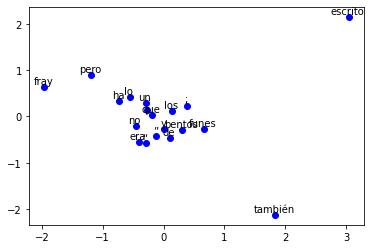

In [13]:
label = [w[0] for w in sorted(idx.items(), key=itemgetter(1))]
plot_words(C.T[1:20],label[1:20])

Para evalaur el modelo, necesitamos primero definir una función que nos de la probabilidad de las cadenas. Definimos esta función a continuación

In [14]:
def prob_sent(sent):
    #Obtenemos los simbolos
    seq = sent.split()
    #Obtenemos los bigramas de la cadena de evaluacion
    bigrSeq = zip(seq,seq[1:])
    
    #Guardamos la probabilidad inicial dado el modelo
    try:
        p = forward(idx['<BOS>'])[idx[seq[0]]]
    except: 
        p = forward(idx['<BOS>'])[idx['<oov>']]
    #Multiplicamos por las probabilidades de los bigramas dado el modelo
    for gram1, gram2 in bigrSeq:
        #Obtiene las probabilidades de transición
        #Dado el primer elemento
        try:
            prev_prob = forward(idx[gram1])
        #En caso de que sea una OOV
        except:
            prev_prob = forward(idx['<oov>'])
        #Obtiene la probabilidad de transitar a la siguiente palabra
        try:
            p *= prev_prob[idx[gram2]]
        #En caso de que sea una OOV
        except:
            p *= prev_prob[idx['<oov>']]
            
    return p

Para valuar el modelo se utilizará la entropía empírica (tomamos el promedio por cadena de ésta). 

La _entropía_ nos dice que tan incierto, es un sistema, por lo que un evento puede predecirse con mayor facilidad si presenta menor entropía, es decir, menos incertidumbre.

Para efectos prácticamos y de comparación, tomese en cuenta que la entropía de lanzar una moneda es 1.

Asimismo, con base en la entropía empírica podemos obtener la perplejidad como: 

$$Px(\mu) = 2^{H_E(\mu)}$$

Esta última medida puede verse como el inverso multiplicativo de la probabilidad asignada al conjunto de pruebas por el modelo de lenguaje. Por lo tanto, tenemos que procurar que tenga un valor relativamente pequeño.

In [15]:
#Evaluación del modelo
H = 0.0
for cad in corpus_eval:
    #Probabilidad de la cadena
    p_cad = prob_sent(' '.join(cad))
    #Longitud de la cadena
    M = len(cad)
    #Obtenemos la entropía cruzada de la cadena
    if p_cad == 0:
        pass
    else:
        H -= (1./M)*(np.log(p_cad)/np.log(2))
        
H = H/len(corpus_eval)

print('Entropía promedio: {}\nPerplejidad total: {}'.format(H,2**H))

Entropía promedio: 4.714470661614007
Perplejidad total: 26.25409683934701


### 6. Calcular la probabilidad de 5 oraciones no vistas en el entrenamiento.

In [16]:
sents_not_seen = ['los ojos cerrados','los amigos','la niña','noticia negativa','el cielo estrellado']

for sent in sents_not_seen:
    print("{}: {}".format(sent,prob_sent(sent)))


los ojos cerrados: 3.595871776051738e-05
los amigos: 0.014433750015787911
la niña: 0.014491615938017748
noticia negativa: 0.01947038280006786
el cielo estrellado: 3.89120871533712e-05


In [17]:
# 7. Guardar los vectores de la capa de embedding asociados a las palabras